Brian Brogan & Richard Trinh

CS453: Interactive Systems II

29 April, 2025

This notebook is to be used to generate plots for pilot study results for the social media glove sensor and design friction implementations

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

#import scripts.clean_data as cd
#import scripts.analyze_data as ad


In [65]:
#cd.process_data()

In [66]:
SCRIPT_DIR = os.path.dirname(os.path.abspath("../scripts"))
RAW_DIR = os.path.join(SCRIPT_DIR, ".../raw")
#EDITED_DIR = os.path.join(SCRIPT_DIR, "../edited")
EDITED_DIR = "./edited"

P1_FILE = os.path.join(EDITED_DIR, "p1.csv")
P2_FILE = os.path.join(EDITED_DIR, "p2.csv")
P3_FILE = os.path.join(EDITED_DIR, "p3.csv")
P4_FILE = os.path.join(EDITED_DIR, "p4.csv")

print(P1_FILE)
print(P2_FILE)
print(P3_FILE)
print(P4_FILE)

./edited/p1.csv
./edited/p2.csv
./edited/p3.csv
./edited/p4.csv


In [67]:
test_id = 2

participants = [P1_FILE, P2_FILE, P3_FILE, P4_FILE]

In [68]:
id_df = pd.read_csv(participants[test_id])
fric_order = id_df["friction_type"].drop_duplicates().values
for fric in fric_order:
    print(fric)
id_df.head()

cal
vis
aud
vib
all


,time_sec,scroll_freq,is_tap,friction_type,content_type
0,12.097,15.6,0,cal,long
1,15.691,15.6,0,cal,long
2,16.451,15.4,0,cal,long
3,30.674,15.4,0,cal,long
4,107.208,18.2,0,cal,long


In [69]:
deltas = {fric: [] for fric in fric_order}

for fric in fric_order:
    fric_subset = id_df[id_df["friction_type"] == fric]
    fric_subset = fric_subset.reset_index(drop=True)  
    for j in range(len(fric_subset) - 1):
        delta = round(fric_subset.loc[j + 1, "time_sec"] - fric_subset.loc[j, "time_sec"], 2)
        deltas[fric].append(delta)

#print(deltas)

In [70]:
fric_order = ["cal", "vis", "aud", "vib", "all"]

# Initialize the dataframe
freq_df = pd.DataFrame(index=["average", "std_dev"], columns=fric_order)

# Fill in the averages and standard deviations
for fric in fric_order:
    values = deltas[fric]
    avg = round(np.mean(values), 2)
    std = round(np.std(values, ddof=1), 2)  # sample std dev

    freq_df.loc["average", fric] = avg
    freq_df.loc["std_dev", fric] = std

# Optional: print the dataframe
freq_df.head()



,cal,vis,aud,vib,all
average,18.92,18.08,14.17,11.67,17.32
std_dev,25.41,27.23,16.91,8.83,26.63


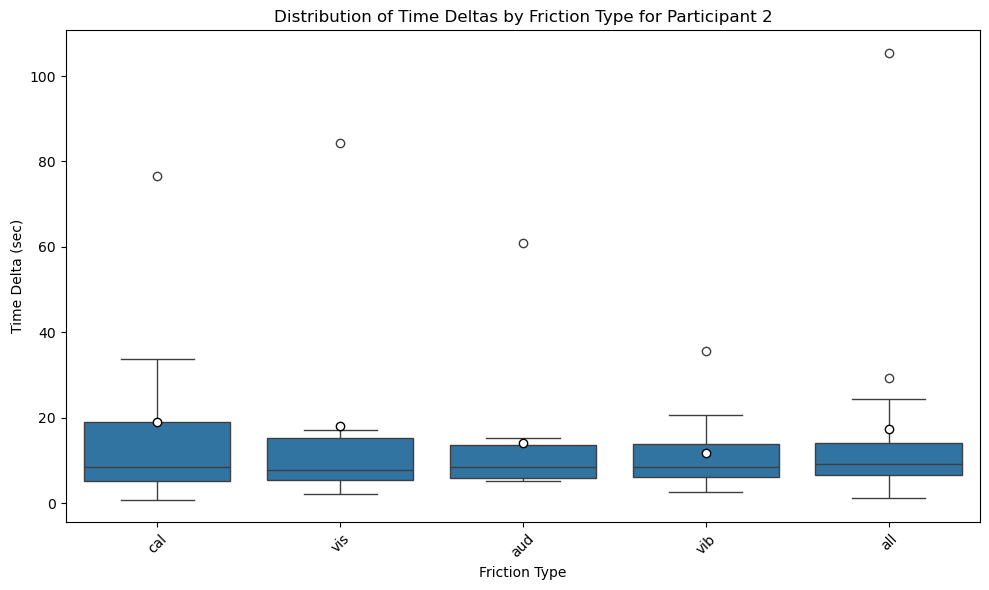

In [71]:
plot_data = pd.DataFrame([
    {"friction_type": fric, "delta": val}
    for fric, deltas_list in deltas.items()
    for val in deltas_list
])

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_data,
            x="friction_type",
            y="delta",
            showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black"},
            whis=1.5)

# Optional enhancements
plt.title(f"Distribution of Time Deltas by Friction Type for Participant {test_id}")
plt.xlabel("Friction Type")
plt.ylabel("Time Delta (sec)")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [72]:
df_list = []
for idx, path in enumerate(participants):
    df = pd.read_csv(path)
    df['part_id'] = idx
    df_list.append(df)

full_df = pd.concat(df_list, ignore_index=True)

print(np.unique(participants))
print(np.unique(full_df["part_id"]))
#print(df_list)


print(np.unique(full_df.loc[full_df['part_id'] == 3]["content_type"]))


['./edited/p1.csv' './edited/p2.csv' './edited/p3.csv' './edited/p4.csv']
[0 1 2 3]
['long']


In [73]:
analysis_df = pd.DataFrame(columns = [
    "part_id",
    "content_type",
    "cal_delta_arr",
    "vis_delta_arr",
    "aud_delta_arr",
    "vib_delta_arr",
    "all_delta_arr",
    "Visual Avg. Delta",
    "Auditory Avg. Delta",
    "Vibration Avg. Delta",
    "All Avg. Delta"
])

part_ids = full_df['part_id'].unique()
cont_types = full_df['content_type'].unique()

delta_arrs = ["cal_delta_arr", "vis_delta_arr", "aud_delta_arr", "vib_delta_arr", "all_delta_arr"]
#tslots = ["calvisT", "calaudT", "calvibT", "calallT"]
#pslots = ["calvisP", "calaudP", "calvibP", "calallP"]
zslots = ["Visual Z-Score", "Auditory Z-Score", "Vibration Z-Score", "All Z-Score"]
mean_diffs = ["Visual Avg. Delta", "Auditory Avg. Delta", "Vibration Avg. Delta", "All Avg. Delta"]

for pid in part_ids:
    sub_df = full_df[(full_df['part_id'] == pid)] # & (full_df['content_type'] == content)]
    deltas = {}

    for friction in ['cal', 'vis', 'aud', 'vib', 'all']:
        fric_df = sub_df[sub_df['friction_type'] == friction].reset_index(drop=True)
        fric_deltas = [round(fric_df.loc[j+1, 'time_sec'] - fric_df.loc[j, 'time_sec'], 2) for j in range(len(fric_df) - 1)]
        deltas[friction] = fric_deltas

    row = {
        "part_id": pid,
        "content_type": sub_df.iloc[0]["content_type"],
        "cal_delta_arr": deltas.get('cal', []),
        "vis_delta_arr": deltas.get('vis', []),
        "aud_delta_arr": deltas.get('aud', []),
        "vib_delta_arr": deltas.get('vib', []),
        "all_delta_arr": deltas.get('all', []),
        "Visual Avg. Delta": round(np.mean(deltas.get('cal', [])) - np.mean(deltas.get('vis', [])), 2),
        "Auditory Avg. Delta": round(np.mean(deltas.get('cal', [])) - np.mean(deltas.get('aud', [])), 2),
        "Vibration Avg. Delta": round(np.mean(deltas.get('cal', [])) - np.mean(deltas.get('vib', [])), 2),
        "All Avg. Delta": round(np.mean(deltas.get('cal', [])) - np.mean(deltas.get('all', [])), 2)

    }

    for i in range(len(tslots)):
        mean_diff = row.get(mean_diffs[i])
        x = row.get(delta_arrs[0])
        y = row.get(delta_arrs[i+1])

        #t_stat, p_value = ttest_ind(x, y, equal_var=False)

        #row[tslots[i]] = round(t_stat,2)
        #row[pslots[i]] = round(p_value,2)

        std_error = np.sqrt(np.var(x, ddof=1)/len(x) + np.var(y, ddof=1)/len(y))
        row[zslots[i]] = round(mean_diff / std_error, 2)

    analysis_df = pd.concat([analysis_df, pd.DataFrame([row])], ignore_index=True)

analysis_df.head()

/var/folders/ly/7twhjt8953j2qysgcl3x0hq40000gn/T/ipykernel_64070/1159264237.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis_df = pd.concat([analysis_df, pd.DataFrame([row])], ignore_index=True)


,part_id,content_type,cal_delta_arr,vis_delta_arr,aud_delta_arr,vib_delta_arr,all_delta_arr,Visual Avg. Delta,Auditory Avg. Delta,Vibration Avg. Delta,All Avg. Delta,Visual Z-Score,Auditory Z-Score,Vibration Z-Score,All Z-Score
0,0,short,"[0.96, 1.54, 12.2, 15.87, 0.99, 8.61, 3.85, 12...","[4.08, 5.34, 0.51, 0.68, 34.07, 0.56, 10.35, 1...","[59.38, 0.56, 51.41, 0.61, 0.89, 13.42, 0.51, ...","[1.06, 4.08, 4.46, 9.64, 10.73, 0.58, 2.0, 14....","[0.66, 1.7, 1.19, 9.47, 4.51, 0.51, 22.78, 7.6...",6.13,-2.02,-0.34,5.80,1.49,-0.29,-0.06,1.41
1,1,short,"[4.71, 0.56, 0.51, 1.22, 1.47, 0.78, 0.51, 0.7...","[2.88, 0.68, 3.7, 1.27, 8.83, 0.68, 4.18, 0.71...","[0.58, 0.79, 10.33, 0.61, 1.54, 0.66, 0.51, 4....","[2.15, 1.16, 0.58, 0.76, 4.23, 3.27, 1.27, 2.0...","[2.23, 0.51, 0.94, 1.85, 0.89, 4.53, 0.51, 0.6...",-1.49,-0.53,0.32,-1.30,-2.24,-0.94,0.87,-1.93
2,2,long,"[3.59, 0.76, 14.22, 76.53, 5.72, 7.85, 8.96, 3...","[5.19, 2.07, 7.8, 84.3, 7.8, 5.49, 17.21, 14.75]","[10.55, 61.0, 5.87, 6.15, 5.8, 12.83, 13.87, 1...","[2.58, 9.52, 6.12, 11.74, 35.69, 17.08, 6.1, 8...","[24.42, 1.14, 14.38, 9.09, 6.15, 2.35, 9.47, 8...",0.84,4.75,7.24,1.59,0.06,0.45,0.78,0.14
3,3,long,"[1.44, 0.56, 1.14, 0.61, 29.28, 25.19, 4.38, 0...","[2.78, 2.03, 1.47, 2.46, 12.55, 1.72, 3.27, 0....","[1.34, 0.61, 0.74, 2.15, 1.04, 1.17, 3.29, 1.1...","[0.51, 0.76, 0.51, 0.53, 0.51, 0.78, 2.25, 0.7...","[7.19, 2.41, 0.99, 0.76, 3.7, 1.75, 1.72, 0.94...",0.66,-0.52,0.88,-0.73,1.29,-0.87,1.48,-1.19


In [74]:
dep_var_df = pd.DataFrame(columns=[
    "part_id", "content_type",
    "cal_avg", "vis_avg", "aud_avg", "vib_avg", "all_avg",
    "cal_reg", "vis_reg", "aud_reg", "vib_reg", "all_reg",
    "cal_tot", "vis_tot", "aud_tot", "vib_tot", "all_tot"
])

for i in range(len(analysis_df)):
    row = {
        "part_id": analysis_df.iloc[i]["part_id"],
        "content_type": analysis_df.iloc[i]["content_type"],
        "cal_avg": round(np.mean(analysis_df.iloc[i]["cal_delta_arr"]),2),
        "cal_reg": round(np.std(analysis_df.iloc[i]["cal_delta_arr"]),2),
        "cal_tot": len(analysis_df.iloc[i]["cal_delta_arr"]),
        "vis_avg": round(np.mean(analysis_df.iloc[i]["vis_delta_arr"]),2),
        "vis_reg": round(np.std(analysis_df.iloc[i]["vis_delta_arr"]),2),
        "vis_tot": len(analysis_df.iloc[i]["vis_delta_arr"]),
        "aud_avg": round(np.mean(analysis_df.iloc[i]["aud_delta_arr"]),2),
        "aud_reg": round(np.std(analysis_df.iloc[i]["aud_delta_arr"]),2),
        "aud_tot": len(analysis_df.iloc[i]["aud_delta_arr"]),
        "vib_avg": round(np.mean(analysis_df.iloc[i]["vib_delta_arr"]),2),
        "vib_reg": round(np.std(analysis_df.iloc[i]["vib_delta_arr"]),2),
        "vib_tot": len(analysis_df.iloc[i]["vib_delta_arr"]),
        "all_avg": round(np.mean(analysis_df.iloc[i]["all_delta_arr"]),2),
        "all_reg": round(np.std(analysis_df.iloc[i]["all_delta_arr"]),2),
        "all_tot": len(analysis_df.iloc[i]["all_delta_arr"]),
    }
    dep_var_df = pd.concat([dep_var_df, pd.DataFrame([row])], ignore_index=True)

dep_var_df.transpose().head(17)

/var/folders/ly/7twhjt8953j2qysgcl3x0hq40000gn/T/ipykernel_64070/539492943.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dep_var_df = pd.concat([dep_var_df, pd.DataFrame([row])], ignore_index=True)


,0,1,2,3
part_id,0,1,2,3
content_type,short,short,long,long
cal_avg,10.98,1.94,18.92,2.35
vis_avg,4.85,3.43,18.08,1.69
aud_avg,13.0,2.48,14.17,2.87
vib_avg,11.32,1.62,11.67,1.47
all_avg,5.18,3.24,17.32,3.08
cal_reg,14.65,3.56,23.77,6.2
vis_reg,7.06,3.81,25.47,1.71
aud_reg,19.53,3.56,16.04,2.6


In [77]:
array_cols = ["cal_delta_arr", "vis_delta_arr", "aud_delta_arr", "vib_delta_arr", "all_delta_arr"]
filtered_df = analysis_df.drop(columns=array_cols).reset_index(drop=True)

vert_analysis_df = filtered_df.transpose()

vert_analysis_df.to_csv("analysis_no_arrs.csv")

vert_analysis_df.head(23)

,0,1,2,3
part_id,0,1,2,3
content_type,short,short,long,long
Visual Avg. Delta,6.13,-1.49,0.84,0.66
Auditory Avg. Delta,-2.02,-0.53,4.75,-0.52
Vibration Avg. Delta,-0.34,0.32,7.24,0.88
All Avg. Delta,5.8,-1.3,1.59,-0.73
Visual Z-Score,1.49,-2.24,0.06,1.29
Auditory Z-Score,-0.29,-0.94,0.45,-0.87
Vibration Z-Score,-0.06,0.87,0.78,1.48
All Z-Score,1.41,-1.93,0.14,-1.19


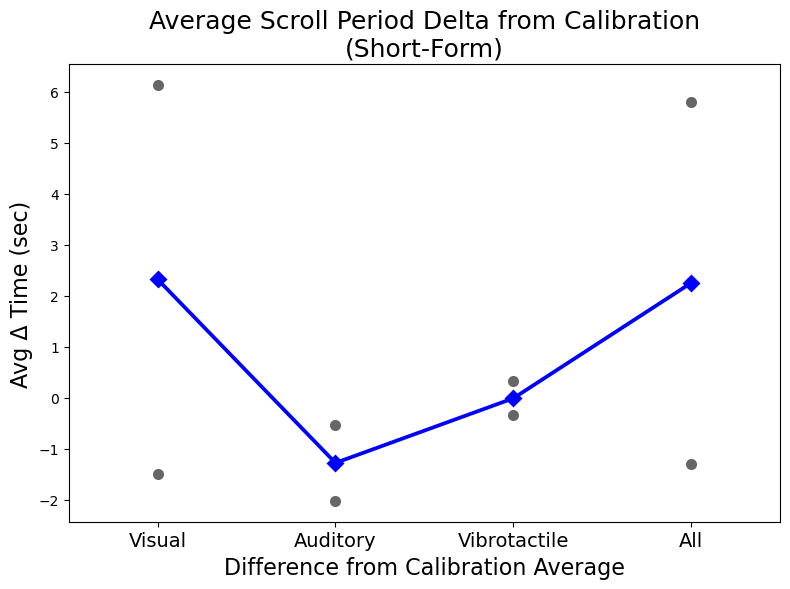

In [78]:
short_df = analysis_df[analysis_df["content_type"] == "short"]

short_melted = short_df.melt(
    id_vars=["part_id"],
    value_vars=["Visual Avg. Delta", "Auditory Avg. Delta", "Vibration Avg. Delta", "All Avg. Delta"],
    var_name="delta_type",
    value_name="avg_delta"
)

custom_labels = ["Visual", "Auditory", "Vibrotactile", "All"]

plt.figure(figsize=(8, 6))

# Plot individual points
sns.stripplot(data=short_melted, x="delta_type", y="avg_delta", jitter=False, size=8, color="black", alpha=0.6)

# Calculate means
mean_values = short_melted.groupby("delta_type")["avg_delta"].mean()

# Overlay means
sns.pointplot(data=short_melted, x="delta_type", y="avg_delta", estimator="mean",
              errorbar=None, color="blue", markers="D")

plt.title("Average Scroll Period Delta from Calibration\n(Short-Form)", fontsize=18)
plt.ylabel("Avg Δ Time (sec)", fontsize=16)
plt.xlabel("Difference from Calibration Average", fontsize=16)
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=14)
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

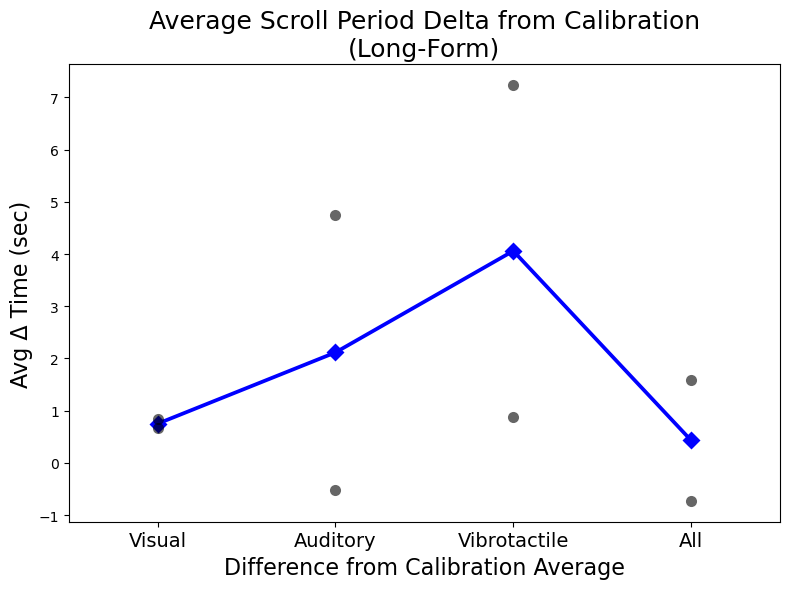

In [79]:
long_df = analysis_df[analysis_df["content_type"] == "long"]

long_melted = long_df.melt(
    id_vars=["part_id"],
    value_vars=["Visual Avg. Delta", "Auditory Avg. Delta", "Vibration Avg. Delta", "All Avg. Delta"],
    var_name="delta_type",
    value_name="avg_delta"
)

custom_labels = ["Visual", "Auditory", "Vibrotactile", "All"]

plt.figure(figsize=(8, 6))

# Plot individual points
sns.stripplot(data=long_melted, x="delta_type", y="avg_delta", jitter=False, size=8, color="black", alpha=0.6)

# Calculate means
mean_values = long_melted.groupby("delta_type")["avg_delta"].mean()

# Overlay means
sns.pointplot(data=long_melted, x="delta_type", y="avg_delta", estimator="mean",
              errorbar=None, color="blue", markers="D")

plt.title("Average Scroll Period Delta from Calibration\n(Long-Form)", fontsize=18)
plt.ylabel("Avg Δ Time (sec)", fontsize=16)
plt.xlabel("Difference from Calibration Average", fontsize=16)
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, fontsize=14)
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

***ANOVA TEST for variance across content type***

**SMGS RESULTS**

In [80]:
anova_melt = analysis_df[
    ["content_type",
    "cal_delta_arr",
    "vis_delta_arr",
    "aud_delta_arr",
    "vib_delta_arr",
    "all_delta_arr"]
].melt(
    id_vars=["content_type"],
    value_vars=["cal_delta_arr", "vis_delta_arr", "aud_delta_arr", "vib_delta_arr", "all_delta_arr"],
    var_name="delta_type",
    value_name="delta"
)

anova_exploded = anova_melt.explode("delta").dropna()
anova_exploded["delta"] = anova_exploded["delta"].astype(float)

print(anova_exploded.shape)
anova_exploded.head()

(981, 3)


,content_type,delta_type,delta
0,short,cal_delta_arr,0.96
0,short,cal_delta_arr,1.54
0,short,cal_delta_arr,12.20
0,short,cal_delta_arr,15.87
0,short,cal_delta_arr,0.99


In [81]:
model = ols('delta ~ C(content_type) * C(delta_type)', data=anova_exploded).fit()

# Perform ANOVA (Type II is recommended for balanced designs)
anova_results = anova_lm(model, typ=2)

print(anova_results)

                                     sum_sq     df         F    PR(>F)
C(content_type)                   13.269299    1.0  0.214173  0.643619
C(delta_type)                    647.834896    4.0  2.614099  0.034043
C(content_type):C(delta_type)    212.938076    4.0  0.859233  0.487924
Residual                       60159.119153  971.0       NaN       NaN


**SURVEY RESULTS**

In [82]:
q_fpath = 'questionaire.csv'
q_df = pd.read_csv(q_fpath)

anova_q_df = q_df[["design friction", "content type", "rating"]]

anova_q_df = anova_q_df.rename(columns={
    "design friction": "design_friction",
    "content type": "content_type"
})

anova_q_df.head()

,design_friction,content_type,rating
0,visual,short,2
1,auditory,short,9
2,vibration,short,8
3,all,short,6
4,visual,short,3


In [83]:
model = ols('rating ~ C(content_type) * C(design_friction)', data=anova_q_df).fit()

# Perform ANOVA (Type II is recommended for balanced designs)
anova_q_results = anova_lm(model, typ=2)

print(anova_q_results)

                                     sum_sq   df          F    PR(>F)
C(content_type)                      0.5625  1.0   1.000000  0.346594
C(design_friction)                  59.6875  3.0  35.370370  0.000058
C(content_type):C(design_friction)   9.1875  3.0   5.444444  0.024666
Residual                             4.5000  8.0        NaN       NaN
